In [1]:
import collections
import pathlib

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization

import tensorflow_datasets as tfds


In [3]:
# import tensorflow_text as tf_text

In [4]:
pip install --quiet "tensorflow-text==2.8.*"

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow-text==2.8.* (from versions: none)
ERROR: No matching distribution found for tensorflow-text==2.8.*


In [5]:
# pip install tensorflow_datasets

Example 1: Predict the tag for a Stack Overflow question
As a first example, you will download a dataset of programming questions from Stack Overflow. Each question ("How do I sort a dictionary by value?") is labeled with exactly one tag (Python, CSharp, JavaScript, or Java). Your task is to develop a model that predicts the tag for a question. This is an example of multi-class classification—an important and widely applicable kind of machine learning problem.

To implement this task, you'll start with the simplest tools:

keras.utils.text_datasaet_from_directory: for loading text-file examples.
keras.layers.TextVectorization: for converting strings to token indices.
Download and explore the dataset
Begin by downloading the Stack Overflow dataset using tf.keras.utils.get_file, and exploring the directory structure:

In [6]:
import os

In [7]:
data_url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

dataset_dir = utils.get_file(
    origin=data_url,
    untar=True,
    cache_dir='stack_overflow',
    cache_subdir=os.getcwd())

dataset_dir = pathlib.Path(dataset_dir).parent

In [8]:
dataset_dir

WindowsPath('d:/a27_YEARS_OLD/deep_learning/load_preprocess')

In [9]:
list(dataset_dir.iterdir())

[WindowsPath('d:/a27_YEARS_OLD/deep_learning/load_preprocess/animation.gif'),
 WindowsPath('d:/a27_YEARS_OLD/deep_learning/load_preprocess/csv.ipynb'),
 WindowsPath('d:/a27_YEARS_OLD/deep_learning/load_preprocess/datasets'),
 WindowsPath('d:/a27_YEARS_OLD/deep_learning/load_preprocess/fonts.zip'),
 WindowsPath('d:/a27_YEARS_OLD/deep_learning/load_preprocess/fonts_extracted'),
 WindowsPath('d:/a27_YEARS_OLD/deep_learning/load_preprocess/heart.csv'),
 WindowsPath('d:/a27_YEARS_OLD/deep_learning/load_preprocess/images.ipynb'),
 WindowsPath('d:/a27_YEARS_OLD/deep_learning/load_preprocess/Metro_Interstate_Traffic_Volume.csv.gz'),
 WindowsPath('d:/a27_YEARS_OLD/deep_learning/load_preprocess/mnist.npz'),
 WindowsPath('d:/a27_YEARS_OLD/deep_learning/load_preprocess/numpy.ipynb'),
 WindowsPath('d:/a27_YEARS_OLD/deep_learning/load_preprocess/pandas.ipynb'),
 WindowsPath('d:/a27_YEARS_OLD/deep_learning/load_preprocess/stack_overflow_16k.tar.gz'),
 WindowsPath('d:/a27_YEARS_OLD/deep_learning/load_

In [10]:
train_dir = dataset_dir/'stack_overflow_16k.tar.gz/train'
list(train_dir.iterdir())

[WindowsPath('d:/a27_YEARS_OLD/deep_learning/load_preprocess/stack_overflow_16k.tar.gz/train/csharp'),
 WindowsPath('d:/a27_YEARS_OLD/deep_learning/load_preprocess/stack_overflow_16k.tar.gz/train/java'),
 WindowsPath('d:/a27_YEARS_OLD/deep_learning/load_preprocess/stack_overflow_16k.tar.gz/train/javascript'),
 WindowsPath('d:/a27_YEARS_OLD/deep_learning/load_preprocess/stack_overflow_16k.tar.gz/train/python')]

Load the dataset
Next, you will load the data off-disk and prepare it into a format suitable for training. To do so, you will use the tf.keras.utils.text_dataset_from_directory utility to create a labeled tf.data.Dataset. If you're new to tf.data, it's a powerful collection of tools for building input pipelines

In [11]:
batch_size = 32
seed = 42

raw_train_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [12]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(10):
    print("Question: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Question:  b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default con

In [13]:
raw_train_ds.class_names

['csharp', 'java', 'javascript', 'python']

In [14]:
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [15]:
# Create a validation set.
raw_val_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [16]:
test_dir = dataset_dir/'stack_overflow_16k.tar.gz/test'

# Create a test set.
raw_test_ds = utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


Configure the datasets for performance
These are two important methods you should use when loading data to make sure that I/O does not become blocking.

Dataset.cache keeps data in memory after it's loaded off-disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.
Dataset.prefetch overlaps data preprocessing and model execution while training.

In [17]:
raw_train_ds = raw_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_test_ds = raw_test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Prepare the dataset for training
Next, you will standardize, tokenize, and vectorize the data using the tf.keras.layers.TextVectorization layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset.
Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words by splitting on whitespace).
Vectorization refers to converting tokens into numbers so they can be fed into a neural network.

The default standardization converts text to lowercase and removes punctuation (standardize='lower_and_strip_punctuation').
The default tokenizer splits on whitespace (split='whitespace').
The default vectorization mode is 'int' (output_mode='int'). This outputs integer indices (one per token). This mode can be used to build models that take word order into account. You can also use other modes—like 'binary'—to build bag-of-words models.
You will build two models to learn more about standardization, tokenization, and vectorization with TextVectorization:

First, you will use the 'binary' vectorization mode to build a bag-of-words model.
Then, you will use the 'int' mode with a 1D ConvNet.

In [18]:
VOCAB_SIZE = 10000

binary_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='binary')

In [19]:
binary_vectorize_layer # object of TextVectorization()  class

<TextVectorization name=text_vectorization, built=False>

For the 'int' mode, in addition to maximum vocabulary size, you need to set an explicit maximum sequence length (MAX_SEQUENCE_LENGTH), which will cause the layer to pad or truncate sequences to exactly output_sequence_length values:

In [20]:
MAX_SEQUENCE_LENGTH = 250

int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

Next, call TextVectorization.adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

In [21]:
# Make a text-only dataset (without labels), then call `TextVectorization.adapt`.
train_text = raw_train_ds.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

Print the result of using these layers to preprocess data

In [22]:
# Retrieve a batch (of 32 reviews and labels) from the dataset.
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question:", first_question)
print("Label:", first_label)

Question: tf.Tensor(b'"blank8 why is my solution faster than the neat solution? (hackerrank chocolate feast) edit: simplified my solution..edit: removed opinion based secondary question...background: atarted learning blank a week or two ago using hackerranks problems as exercises and stackoverflow search + google as my teacher, i\'ve had some limited experience learning other languages...i did the exercise my own ""noobish learner way"" which i can\'t help but feel is a ""botched job"" when i see ""neat &amp; short"" solutions...however, when submitting both solutions one after another a couple of times i found the ""neat"" solution was quite a bit slower. ..i vaguely remember something about % operations being costly, is mine faster because of no % operations or is there more to it than just that?..exercise: https://www.hackerrank.com/challenges/chocolate-feast..neat solution from discussion:..import blank.io.*;.import blank.util.*;..public class solution {.    static int cc; .    pub

The binary vectorization layer returns a multi-hot vector, with a 1 in the location for each token that was in the input string.

'binary' vectorized question: [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int6

(0.0, 1000.0)

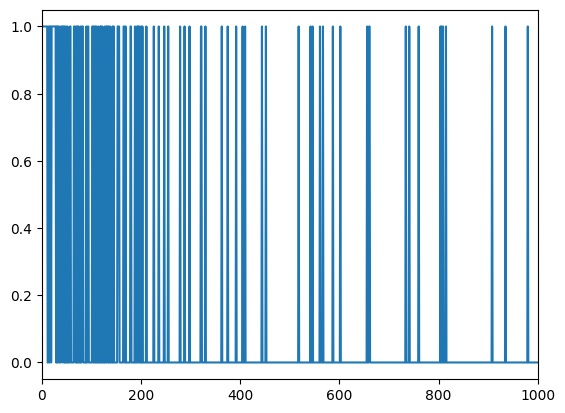

In [23]:
print("'binary' vectorized question:",
      list(binary_vectorize_layer(first_question).numpy()))

plt.plot(binary_vectorize_layer(first_question).numpy())
plt.xlim(0,1000)

In [24]:
print("'int' vectorized question:",
      int_vectorize_layer(first_question).numpy())

'int' vectorized question: [   1  111    6   23  299 1787  198    2 3623  299 7826    1    1  805
 2568   23    1 1218 3892  364 4145    1    1  661   16    5  981   45
  121 1881   47    1  742   36 9987    8 1982  322  662   36   23 2362
  195  543   83 2693 2609  661  144    1  411    2 1371   23  657    1
 6520   84   66    3  166  104   26 1182    6    5    1 1639   44    3
  189 3623  519 1135    1   44 5468  280 1272   71  156  157    5 1759
    9  331    3  227    2 3623  299  115  810    5  547 3833    3    1
 2371  146  202 1195  289    1    6 2179 1787  193    9  136 1195   45
    6   67  181    4   11  198  106    1    1  299   31    1 2216 1924
   29  299   53   28 2081   22   53   42  170  154  256    7   15  453
   28    1  237 2698    1  134 2698  131 2698  323 2698    1    1    1
    1    1    1   23    1 2216 1924   29  299   22   53   42  170  154
  256 1360   15  453   28  237    1  237   68    9  196  807   28 7167
    1  237    1 1364    1  562    1 4406  735 1820

As shown above, TextVectorization's 'binary' mode returns an array denoting which tokens exist at least once in the input, while the 'int' mode replaces each token by an integer, thus preserving their order.

You can lookup the token (string) that each integer corresponds to by calling TextVectorization.get_vocabulary on the layer:

In [25]:
print("1289 ---> ", int_vectorize_layer.get_vocabulary()[1289])
print("313 ---> ", int_vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(int_vectorize_layer.get_vocabulary())))

1289 --->  roman
313 --->  source
Vocabulary size: 10000


Train the model
It's time to create your neural network.

For the 'binary' vectorized data, define a simple bag-of-words linear model, then configure and train it:

In [26]:
binary_model = tf.keras.Sequential([
    binary_vectorize_layer,
    layers.Dense(4)])


In [27]:
binary_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 10000)          │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:

binary_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])


In [29]:

# tf.keras.utils.plot_model(binary_model, show_shapes=True)

In [30]:
bin_history = binary_model.fit(
    raw_train_ds, validation_data=raw_val_ds, epochs=10)

print()

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.5090 - loss: 1.2470 - val_accuracy: 0.7794 - val_loss: 0.9155
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8176 - loss: 0.8219 - val_accuracy: 0.8012 - val_loss: 0.7503
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8643 - loss: 0.6531 - val_accuracy: 0.8144 - val_loss: 0.6644
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8883 - loss: 0.5530 - val_accuracy: 0.8238 - val_loss: 0.6108
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9001 - loss: 0.4837 - val_accuracy: 0.8344 - val_loss: 0.5741
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9150 - loss: 0.4315 - val_accuracy: 0.8375 - val_loss: 0.5474
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9249 - loss: 0.3900 - val_accuracy: 0.8375 - val_loss: 0.5273
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9332 - loss: 0.3559 - val_accuracy: 

you will use the 'int' vectorized layer to build a 1D ConvNet:

In [ ]:
def create_model(vocab_size, num_labels, vectorizer=None):
  my_layers =[]
  if vectorizer is not None:
    my_layers = [vectorizer]

  my_layers.extend([
      layers.Embedding(vocab_size, 64, mask_zero=True),   #vocab_size: The size of the vocabulary (input dimension).
      # 64: The dimension of the dense embedding (output dimension).
      # mask_zero=True: Masks the zero index, typically used for padding tokens.
      layers.Dropout(0.5),
      layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
      layers.GlobalMaxPooling1D(),
      layers.Dense(num_labels)
  ])

  model = tf.keras.Sequential(my_layers)
  return model

In [33]:
# `vocab_size` is `VOCAB_SIZE + 1` since `0` is used additionally for padding.
int_model = create_model(vocab_size=VOCAB_SIZE + 1, num_labels=4, vectorizer=int_vectorize_layer)

# tf.keras.utils.plot_model(int_model, show_shapes=True)

In [40]:
int_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 250)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 250, 64)        │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 123, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,982,606 (7.56 MB)

 Trainable params: 660,868 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,321,738 (5.04 MB)

Without from_logits=True: The loss function applies softmax normalization to the outputs, potentially leading to numerical instability.
With from_logits=True: The loss function assumes the outputs are logits and computes the cross-entropy loss directly, improving stability.

In [34]:
int_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
int_history = int_model.fit(raw_train_ds, validation_data=raw_val_ds, epochs=10)

Epoch 1/10


d:\a27_YEARS_OLD\deep_learning\venv\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.3174 - loss: 1.3434 - val_accuracy: 0.6275 - val_loss: 0.8895
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6527 - loss: 0.8370 - val_accuracy: 0.7544 - val_loss: 0.6273
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7769 - loss: 0.5952 - val_accuracy: 0.7956 - val_loss: 0.5390
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8488 - loss: 0.4367 - val_accuracy: 0.8081 - val_loss: 0.4977
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8983 - loss: 0.3167 - val_accuracy: 0.8119 - val_loss: 0.4960
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9378 - loss: 0.2268 - val_accuracy: 0.8106 - val_loss: 0.5105
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9610 - loss: 0.1551 - val_accuracy: 0.8156 - val_loss: 0.5297
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9728 - loss: 0.1126 - val_accuracy: 0.81

Text(0, 0.5, 'CE/token')

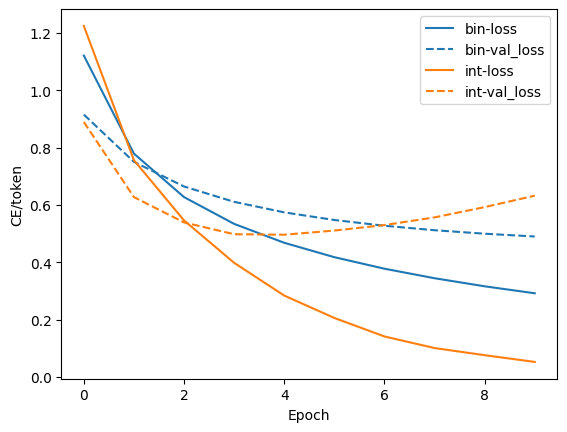

In [35]:
loss = plt.plot(bin_history.epoch, bin_history.history['loss'], label='bin-loss')
plt.plot(bin_history.epoch, bin_history.history['val_loss'], '--', color=loss[0].get_color(), label='bin-val_loss')

loss = plt.plot(int_history.epoch, int_history.history['loss'], label='int-loss')
plt.plot(int_history.epoch, int_history.history['val_loss'], '--', color=loss[0].get_color(), label='int-val_loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('CE/token')

You are nearly ready to train your model.

As a final preprocessing step, you will apply the TextVectorization layers you created earlier to the training, validation, and test sets

In [36]:
binary_train_ds = raw_train_ds.map(lambda x,y: (binary_vectorize_layer(x), y))
binary_val_ds = raw_val_ds.map(lambda x,y: (binary_vectorize_layer(x), y))
binary_test_ds = raw_test_ds.map(lambda x,y: (binary_vectorize_layer(x), y))

int_train_ds = raw_train_ds.map(lambda x,y: (int_vectorize_layer(x), y))
int_val_ds = raw_val_ds.map(lambda x,y: (int_vectorize_layer(x), y))
int_test_ds = raw_test_ds.map(lambda x,y: (int_vectorize_layer(x), y))

In [37]:
binary_model.export('bin.tf')

INFO:tensorflow:Assets written to: bin.tf\assets


INFO:tensorflow:Assets written to: bin.tf\assets


Saved artifact at 'bin.tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None,), dtype=tf.string, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2309263289872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2309263290256: TensorSpec(shape=(), dtype=tf.int64, name=None)
  2309263283920: TensorSpec(shape=(), dtype=tf.string, name=None)
  2309263281616: TensorSpec(shape=(), dtype=tf.int64, name=None)
  2309263101584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2309263104464: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [38]:
loaded = tf.saved_model.load('bin.tf')

In [42]:
binary_model.predict(['How do you sort a list?'])

ValueError: Unrecognized data type: x=['How do you sort a list?'] (of type <class 'list'>)

In [43]:
loaded.serve(tf.constant(['How do you sort a list?'])).numpy()

array([[-0.07642995,  0.03005568, -0.5993023 ,  0.39870143]],
      dtype=float32)

xample 2: Predict the author of Iliad translations
The following provides an example of using tf.data.TextLineDataset to load examples from text files, and TensorFlow Text to preprocess the data. You will use three different English translations of the same work, Homer's Iliad, and train a model to identify the translator given a single line of text.

To implement this task you'll use some lower level tools.

You'll use tf.data.TextLineDataset to load text-lines from files.
You'll implement your own version of keras.layers.TextVectorization using:
text.UnicodeScriptTokenizer - to convert strings to tokens.
tf.lookup.StaticVocabularyTable - to convert tokens to integer ids.

In [ ]:
DIRECTORY_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
FILE_NAMES = ['cowper.txt', 'derby.txt', 'butler.txt']

In [46]:
for name in FILE_NAMES:
  text_dir = utils.get_file(name, cache_subdir=os.getcwd()+'/'+'translator', origin=DIRECTORY_URL + name)

815980/815980 ━━━━━━━━━━━━━━━━━━━━ 1s 2us/step
809730/809730 ━━━━━━━━━━━━━━━━━━━━ 1s 2us/step
807992/807992 ━━━━━━━━━━━━━━━━━━━━ 1s 2us/step


In [49]:
parent_dir = pathlib.Path(text_dir).parent
list(parent_dir.iterdir())

[WindowsPath('d:/a27_YEARS_OLD/deep_learning/load_preprocess/translator/butler.txt'),
 WindowsPath('d:/a27_YEARS_OLD/deep_learning/load_preprocess/translator/cowper.txt'),
 WindowsPath('d:/a27_YEARS_OLD/deep_learning/load_preprocess/translator/derby.txt')]

Load the dataset
Previously, with tf.keras.utils.text_dataset_from_directory all contents of a file were treated as a single example. Here, you will use tf.data.TextLineDataset, which is designed to create a tf.data.Dataset from a text file where each example is a line of text from the original file. TextLineDataset is useful for text data that is primarily line-based (for example, poetry or error logs).

Iterate through these files, loading each one into its own dataset. Each example needs to be individually labeled, so use Dataset.map to apply a labeler function to each one. This will iterate over every example in the dataset, returning (example, label) pairs.

In [50]:
def labeler(example, index):
  return example, tf.cast(index, tf.int64)

tf.cast(index, tf.int64) converts the data type of the index tensor to tf.int64, which represents 64-bit integers.

In [51]:
labeled_data_sets = []

for i, file_name in enumerate(FILE_NAMES):
  lines_dataset = tf.data.TextLineDataset(str(parent_dir/file_name))
  labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
  labeled_data_sets.append(labeled_dataset)

Lambda function: lambda ex: labeler(ex, i) - applies the labeler function to each line (ex) with argument i.

In [59]:
for i , ex in labeled_dataset:
    print(f' {i}: {ex}')

 b'\xef\xbb\xbfSing, O goddess, the anger of Achilles son of Peleus, that brought': 2
 b'countless ills upon the Achaeans. Many a brave soul did it send': 2
 b'hurrying down to Hades, and many a hero did it yield a prey to dogs and': 2
 b'vultures, for so were the counsels of Jove fulfilled from the day on': 2
 b'which the son of Atreus, king of men, and great Achilles, first fell': 2
 b'out with one another.': 2
 b'And which of the gods was it that set them on to quarrel? It was the': 2
 b'son of Jove and Leto; for he was angry with the king and sent a': 2
 b'pestilence upon the host to plague the people, because the son of': 2
 b'Atreus had dishonoured Chryses his priest. Now Chryses had come to the': 2
 b'ships of the Achaeans to free his daughter, and had brought with him a': 2
 b'great ransom: moreover he bore in his hand the sceptre of Apollo': 2
 b"wreathed with a suppliant's wreath, and he besought the Achaeans, but": 2
 b'most of all the two sons of Atreus, who were their chie

In [56]:
lines_dataset

<TextLineDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [57]:
labeled_data_sets

[<_MapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

 you'll combine these labeled datasets into a single dataset using Dataset.concatenate, and shuffle it with Dataset.shuffle:

In [53]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64
VALIDATION_SIZE = 5000

In [55]:
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
  all_labeled_data = all_labeled_data.concatenate(labeled_dataset)

all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

In [58]:
all_labeled_data

<_ShuffleDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [60]:
for text, label in all_labeled_data.take(10):
  print("Sentence: ", text.numpy())
  print("Label:", label.numpy())

Sentence:  b'Then put on board Chrys\xc3\xabis, and with her'
Label: 0
Sentence:  b"But when the fatal shaft has drain'd his strength,"
Label: 1
Sentence:  b'be supreme--one king to whom the son of scheming Saturn has given the'
Label: 2
Sentence:  b'To whom the Cloud-compeller, smiling, thus:'
Label: 1
Sentence:  b'front rank, while the foot-soldiers, brave men and many, whom he could'
Label: 2
Sentence:  b'Tydides, lashing, as he came, his steeds'
Label: 0
Sentence:  b"Like to a wintry stream, that brimming o'er"
Label: 1
Sentence:  b'Whose King the valiant Diomed hath slain,'
Label: 1
Sentence:  b"Bestow'd them, radiant as the beams of light?"
Label: 1
Sentence:  b'The noble son of Tydeus, spear in hand,'
Label: 0


Prepare the dataset for training
Instead of using tf.keras.layers.TextVectorization to preprocess the text dataset, you will now use the lower-level TensorFlow Text APIs to standardize and tokenize the data, build a vocabulary and use tf.lookup.StaticVocabularyTable to map tokens to integers to feed to the model.

TensorFlow Text provides various tokenizers. In this example, you will use the text.UnicodeScriptTokenizer to tokenize the dataset.
You will use Dataset.map to apply the tokenization to the dataset

In [61]:
class MyTokenizer(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()
    self.tokenizer = tf_text.UnicodeScriptTokenizer()

  def call(self, text):
    lower_case = tf_text.case_fold_utf8(text)
    result = self.tokenizer.tokenize(lower_case)
    # If you pass a batch of strings, it will return a RaggedTensor.
    if isinstance(result, tf.RaggedTensor):
      # Convert to dense 0-padded.
      result = result.to_tensor()
    return result

In [62]:
tokenizer = MyTokenizer()

NameError: name 'tf_text' is not defined

In [ ]:
tokenized_ds = all_labeled_data.map(lambda text, label: (tokenizer(text), label))
tokenized_ds

In [ ]:
for tokens, label in tokenized_ds.take(1):
  break

print(tokens)
print()
print(label)

In [ ]:
tokenized_ds = tokenized_ds.cache().prefetch(tf.data.AUTOTUNE)

vocab_count = collections.Counter()
for toks, labels in tokenized_ds.ragged_batch(1000):
  toks = tf.reshape(toks, [-1])
  for tok in toks.numpy():
    vocab_count[tok] += 1

vocab = [tok for tok, count in vocab_count.most_common(VOCAB_SIZE)]

print("First five vocab entries:", vocab[:5])
print()

In [ ]:
class MyVocabTable(tf.keras.layers.Layer):
  def __init__(self, vocab):
    super().__init__()
    self.keys = [''] + vocab
    self.values = range(len(self.keys))

    self.init = tf.lookup.KeyValueTensorInitializer(
        self.keys, self.values, key_dtype=tf.string, value_dtype=tf.int64)

    num_oov_buckets = 1

    self.table = tf.lookup.StaticVocabularyTable(self.init, num_oov_buckets)

  def call(self, x):
    result = self.table.lookup(x)
    return result

In [ ]:
vocab_table = MyVocabTable(['a','b','c'])
vocab_table(tf.constant([''] + list('abcdefghi')))

In [ ]:
vocab_table = MyVocabTable(vocab)

In [ ]:
preprocess_text = tf.keras.Sequential([
    tokenizer,
    vocab_table
])

In [63]:
example_text, example_label = next(iter(all_labeled_data))
print("Sentence: ", example_text.numpy())
vectorized_text = preprocess_text(example_text)
print("Vectorized sentence: ", vectorized_text.numpy())

Sentence:  b'Then put on board Chrys\xc3\xabis, and with her'


NameError: name 'preprocess_text' is not defined

In [ ]:
all_encoded_data = all_labeled_data.map(lambda text, labels:(preprocess_text(text), labels))

for ids, label in all_encoded_data.take(1):
  break

print("Ids: ", ids.numpy())
print("Label: ", label.numpy())

In [ ]:
train_data = all_encoded_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
validation_data = all_encoded_data.take(VALIDATION_SIZE).padded_batch(BATCH_SIZE)

In [ ]:
sample_text, sample_labels = next(iter(validation_data))
print("Text batch shape: ", sample_text.shape)
print("Label batch shape: ", sample_labels.shape)
print("First text example: ", sample_text[0])
print("First label example: ", sample_labels[0])

In [ ]:
train_data = train_data.prefetch(tf.data.AUTOTUNE)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

In [ ]:
model = create_model(vocab_size=VOCAB_SIZE+2, num_labels=3)

model.compile(
    optimizer='adam',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(train_data, validation_data=validation_data, epochs=3)

In [ ]:
export_model = tf.keras.Sequential([
    preprocess_text,
    model
])

In [ ]:
export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

In [ ]:
# Create a test dataset of raw strings.
test_ds = all_labeled_data.take(VALIDATION_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds

In [ ]:
loss, accuracy = export_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: {:2.2%}".format(accuracy))

In [ ]:
tf.saved_model.save(export_model, 'export.tf')

In [ ]:
loaded = tf.saved_model.load('export.tf')

In [ ]:
export_model(tf.constant(['The field bristled with the long and deadly spears which they bore.'])).numpy()

In [ ]:
loaded(tf.constant(['The field bristled with the long and deadly spears which they bore.'])).numpy()

In [ ]:
inputs = [
    "Join'd to th' Ionians with their flowing robes,",  # Label: 1
    "the allies, and his armour flashed about him so that he seemed to all",  # Label: 2
    "And with loud clangor of his arms he fell.",  # Label: 0
]

predicted_scores = export_model.predict(inputs)
predicted_labels = tf.math.argmax(predicted_scores, axis=1)

for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label.numpy())

you will use the IMDB Large Movie Review dataset to train a model for sentiment classification:

In [65]:
# Training set.
train_ds = tfds.load(
    'imdb_reviews',
    split='train[:80%]',
    batch_size=BATCH_SIZE,
    shuffle_files=True,
    as_supervised=True,
    data_dir=os.getcwd())

Dl Completed...: 100%|██████████| 1/1 [00:08<00:00,  8.17s/ url]


Dataset imdb_reviews downloaded and prepared to d:\a27_YEARS_OLD\deep_learning\load_preprocess\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.



In [67]:
# Validation set.
val_ds = tfds.load(
    'imdb_reviews',
    split='train[80%:]',
    batch_size=BATCH_SIZE,
    shuffle_files=True,
    as_supervised=True,
    data_dir=os.getcwd())

In [68]:
for review_batch, label_batch in val_ds.take(1):
  for i in range(5):
    print("Review: ", review_batch[i].numpy())
    print("Label: ", label_batch[i].numpy())

Review:  b"Instead, go to the zoo, buy some peanuts and feed 'em to the monkeys. Monkeys are funny. People with amnesia who don't say much, just sit there with vacant eyes are not all that funny.<br /><br />Black comedy? There isn't a black person in it, and there isn't one funny thing in it either.<br /><br />Walmart buys these things up somehow and puts them on their dollar rack. It's labeled Unrated. I think they took out the topless scene. They may have taken out other stuff too, who knows? All we know is that whatever they took out, isn't there any more.<br /><br />The acting seemed OK to me. There's a lot of unfathomables tho. It's supposed to be a city? It's supposed to be a big lake? If it's so hot in the church people are fanning themselves, why are they all wearing coats?"
Label:  0
Review:  b'Well, was Morgan Freeman any more unusual as God than George Burns? This film sure was better than that bore, "Oh, God". I was totally engrossed and LMAO all the way through. Carrey was

In [89]:
vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

# Make a text-only dataset (without labels), then call `TextVectorization.adapt`.
train_text = train_ds.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)

UnimplementedError: {{function_node __wrapped__Cast_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cast int64 to string is not supported [Op:Cast] name: 

In [70]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [71]:
train_ds = train_ds.map(vectorize_text)


In [76]:
next(iter(train_ds.take(1)))

(<tf.Tensor: shape=(64, 250), dtype=int64, numpy=
 array([[  11,   14,   34, ...,    0,    0,    0],
        [  10,   26,   75, ...,    0,    0,    0],
        [4246, 6027,    2, ...,    0,    0,    0],
        ...,
        [   4,  657,    3, ..., 3098,   68,   11],
        [3866,   37,   11, ...,    0,    0,    0],
        [  10,  153,  533, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64,), dtype=int64, numpy=
 array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1])>)

In [75]:
for text , label in train_ds.take(1):
    print(text, label)

tf.Tensor(
[[  11   14   34 ...    0    0    0]
 [  10   26   75 ...    0    0    0]
 [4246 6027    2 ...    0    0    0]
 ...
 [   4  657    3 ... 3098   68   11]
 [3866   37   11 ...    0    0    0]
 [  10  153  533 ...    0    0    0]], shape=(64, 250), dtype=int64) tf.Tensor(
[0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1
 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1], shape=(64,), dtype=int64)


In [77]:
val_ds = val_ds.map(vectorize_text)

In [78]:
# Configure datasets for performance as before.
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [79]:
model = create_model(vocab_size=VOCAB_SIZE, num_labels=1)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [80]:
model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

In [81]:
history = model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3


d:\a27_YEARS_OLD\deep_learning\venv\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5276 - loss: 0.6634 - val_accuracy: 0.7980 - val_loss: 0.4323
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8099 - loss: 0.4070 - val_accuracy: 0.8454 - val_loss: 0.3465
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8693 - loss: 0.3038 - val_accuracy: 0.8548 - val_loss: 0.3219


In [82]:
loss, accuracy = model.evaluate(val_ds)

print("Loss: ", loss)
print("Accuracy: {:2.2%}".format(accuracy))

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8563 - loss: 0.3236
Loss:  0.3219113349914551
Accuracy: 85.48%


In [83]:
export_model = tf.keras.Sequential(
    [vectorize_layer, model,
     layers.Activation('sigmoid')])
export_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 250)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 1)              │       660,609 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 660,609 (2.52 MB)

 Trainable params: 660,609 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

In [ ]:
# 0 --> negative review
# 1 --> positive review
inputs = [
    "This is a fantastic movie.",
    "This is a bad movie.",
    "This movie was so bad that it was good.",
    "I will never say yes to watching this movie.",
]

In [91]:
trext = tf.expand_dims("This is a fantastic movie.", -1)

In [92]:
trext

<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'This is a fantastic movie.'], dtype=object)>

In [93]:
model.predict(trext)

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("sequential_3_1/Cast:0", shape=(1,), dtype=float32). Expected shape (None, None), but input has incompatible shape (1,)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1,), dtype=string)
  • training=False
  • mask=None

In [87]:
predicted_scores = export_model.predict( "This is a fantastic movie.")

ValueError: Unrecognized data type: x=This is a fantastic movie. (of type <class 'str'>)

ValueError: Unrecognized data type: x=['This is a fantastic movie.', 'This is a bad movie.', 'This movie was so bad that it was good.', 'I will never say yes to watching this movie.'] (of type <class 'list'>)

In [ ]:
predicted_labels = [int(round(x[0])) for x in predicted_scores]

for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label)